In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# for MNIST data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import os
import torchvision.utils
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [ ]:
batch_size = 64

transforms_train = transforms.Compose([
    transforms.Resize(28), # Image to 28x28로 조정
    transforms.ToTensor(), # Data transform to PyTorch
    transforms.Normalize([0.5], [0.5]) # Normalize pixel value [-1, 1]
])

# MNIST dataset load (Train data)
train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)

# Dataloader
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.10MB/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[tensor(5), tensor(9), tensor(1), tensor(0), tensor(3), tensor(7), tensor(3), tensor(9), tensor(8), tensor(1), tensor(8), tensor(4), tensor(8), tensor(6), tensor(0), tensor(7), tensor(1), tensor(5), tensor(1), tensor(9), tensor(1), tensor(8), tensor(4), tensor(5), tensor(4), tensor(3), tensor(3), tensor(2), tensor(4), tensor(1), tensor(2), tensor(9), tensor(8), tensor(7), tensor(2), tensor(5), tensor(7), tensor(9), tensor(9), tensor(4), tensor(0), tensor(5), tensor(1), tensor(8), tensor(0), tensor(3), tensor(0), tensor(2), tensor(0), tensor(6), tensor(3), tensor(4), tensor(8), tensor(5), tensor(2), tensor(3), tensor(4), tensor(4), tensor(1), tensor(8), tensor(1), tensor(1), tensor(4), tensor(5)]


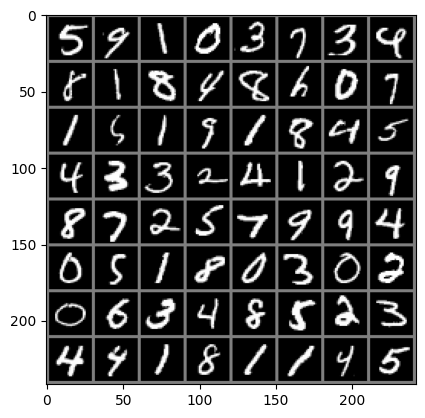

In [ ]:
images, labels = next(iter(dataloader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

"""
Visualize the MNIST dataset

Args:
    dataloader(torch.utils.data.DataLoader): Dataloader object providing batches of images and labels.

Returns:
    Visualizes a grid of images with pixel values normalized
"""

In [ ]:
# image

channels = 1
img_size = 28

img_shape = (channels, img_size, img_size)

In [ ]:
# dimensionality of the latent space
# To extract latent vector in noise distribution's dimension
latent_dim = 100

class Generator(nn.Module):
  """
  Generator class

  Args:
      latent_dim (int): Dimensionality of the latent space.
      img_shape (tuple): Shape of the generated images (channels, height, width)

  Returns:
      Generates an image from a latent vector sampled from a normal distribution
  """

    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # generater model consists of blocks
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        # z : input noise vector
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [ ]:
# Discriminator

class Discriminator(nn.Module):
  """
  Discriminator class

  Args:
      img_shape (tuple): Shape of the input images (channels, height, width)

  Returns:
      Validity (float): Probability of whether the input image is real or fake.
  """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # Return discriminated result of image
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [ ]:
"""
Hyper parameter

Args:
    generator (Generator): Generator model.
    discriminator (Discriminator): Discriminator model.
    lr (float): Learning rate.
    b1, b2 (float): Beta parameters for Adam optimizer.
"""

# learning rate
lr = 0.0002

# decay of first order momentum of gradient
b1 = 0.5
b2 = 0.999


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.BCELoss()

# Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# GPU
cuda = True if torch.cuda.is_available() else False

if cuda :
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


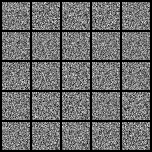

[Epoch 0/200] [D loss: 0.920350] [G loss: 2.940555]
[Epoch 1/200] [D loss: 0.635500] [G loss: 0.459584]


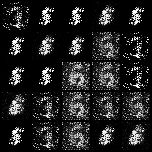

[Epoch 2/200] [D loss: 0.402500] [G loss: 0.661644]
[Epoch 3/200] [D loss: 0.268126] [G loss: 3.176036]


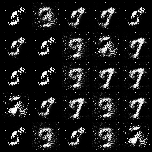

[Epoch 4/200] [D loss: 0.351972] [G loss: 3.067642]
[Epoch 5/200] [D loss: 0.265901] [G loss: 1.347411]


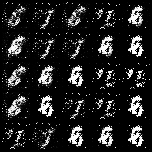

[Epoch 6/200] [D loss: 0.252940] [G loss: 1.119515]
[Epoch 7/200] [D loss: 0.304048] [G loss: 1.656880]


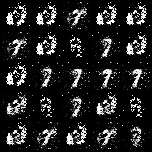

[Epoch 8/200] [D loss: 0.095954] [G loss: 3.016172]
[Epoch 9/200] [D loss: 0.191462] [G loss: 2.712836]


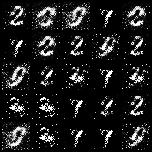

[Epoch 10/200] [D loss: 0.205088] [G loss: 2.340941]
[Epoch 11/200] [D loss: 0.152401] [G loss: 1.692541]


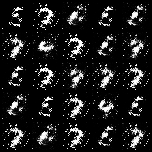

[Epoch 12/200] [D loss: 0.138350] [G loss: 2.521981]
[Epoch 13/200] [D loss: 0.147861] [G loss: 3.054447]


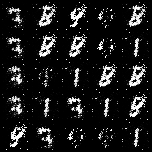

[Epoch 14/200] [D loss: 0.236863] [G loss: 2.715372]
[Epoch 15/200] [D loss: 0.622789] [G loss: 1.105222]
[Epoch 16/200] [D loss: 0.230483] [G loss: 2.723197]


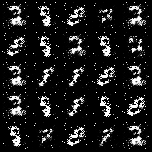

[Epoch 17/200] [D loss: 0.156547] [G loss: 3.116692]
[Epoch 18/200] [D loss: 0.323210] [G loss: 1.435900]


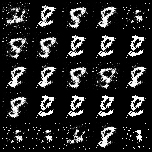

[Epoch 19/200] [D loss: 0.841087] [G loss: 0.458532]
[Epoch 20/200] [D loss: 0.201773] [G loss: 1.467382]


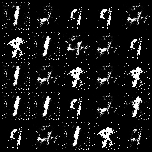

[Epoch 21/200] [D loss: 0.305177] [G loss: 1.160209]
[Epoch 22/200] [D loss: 0.081570] [G loss: 2.856778]


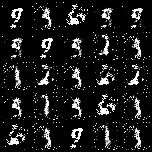

[Epoch 23/200] [D loss: 0.062149] [G loss: 2.879828]
[Epoch 24/200] [D loss: 0.023435] [G loss: 4.165515]


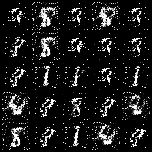

[Epoch 25/200] [D loss: 0.130747] [G loss: 3.880476]
[Epoch 26/200] [D loss: 0.781031] [G loss: 0.292111]


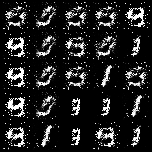

[Epoch 27/200] [D loss: 0.190653] [G loss: 4.052177]
[Epoch 28/200] [D loss: 0.104708] [G loss: 4.246354]


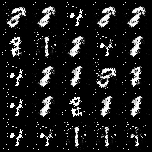

[Epoch 29/200] [D loss: 0.133100] [G loss: 4.116083]
[Epoch 30/200] [D loss: 0.180101] [G loss: 2.370823]


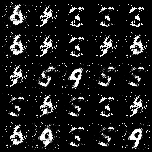

[Epoch 31/200] [D loss: 0.111288] [G loss: 4.343225]
[Epoch 32/200] [D loss: 0.156093] [G loss: 4.260173]
[Epoch 33/200] [D loss: 0.076417] [G loss: 2.255892]


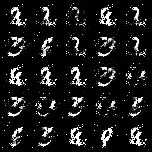

[Epoch 34/200] [D loss: 0.057074] [G loss: 3.533010]
[Epoch 35/200] [D loss: 0.122839] [G loss: 4.037633]


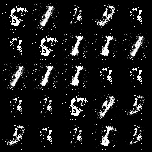

[Epoch 36/200] [D loss: 0.270842] [G loss: 7.647293]
[Epoch 37/200] [D loss: 0.131581] [G loss: 3.004912]


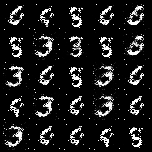

[Epoch 38/200] [D loss: 0.076595] [G loss: 3.272642]
[Epoch 39/200] [D loss: 0.084756] [G loss: 3.683746]


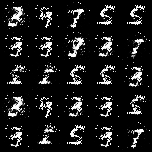

[Epoch 40/200] [D loss: 0.061910] [G loss: 4.134108]
[Epoch 41/200] [D loss: 0.099713] [G loss: 3.144733]


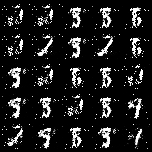

[Epoch 42/200] [D loss: 0.108954] [G loss: 2.755265]
[Epoch 43/200] [D loss: 0.273063] [G loss: 5.586015]


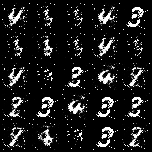

[Epoch 44/200] [D loss: 0.077455] [G loss: 3.075897]
[Epoch 45/200] [D loss: 0.301825] [G loss: 5.866732]


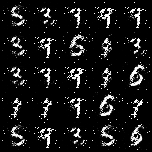

[Epoch 46/200] [D loss: 0.094282] [G loss: 2.612758]
[Epoch 47/200] [D loss: 0.155855] [G loss: 1.720819]
[Epoch 48/200] [D loss: 0.047181] [G loss: 3.327048]


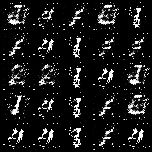

[Epoch 49/200] [D loss: 0.134932] [G loss: 4.085445]
[Epoch 50/200] [D loss: 0.063414] [G loss: 4.647917]


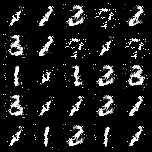

[Epoch 51/200] [D loss: 0.222133] [G loss: 2.418908]
[Epoch 52/200] [D loss: 1.309343] [G loss: 13.611676]


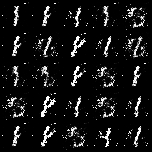

[Epoch 53/200] [D loss: 0.046435] [G loss: 2.739855]
[Epoch 54/200] [D loss: 0.025251] [G loss: 3.625181]


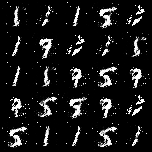

[Epoch 55/200] [D loss: 0.216942] [G loss: 3.965921]
[Epoch 56/200] [D loss: 0.073194] [G loss: 2.707480]


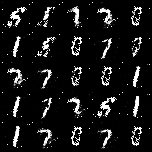

[Epoch 57/200] [D loss: 0.114171] [G loss: 2.320201]
[Epoch 58/200] [D loss: 0.227447] [G loss: 3.209707]


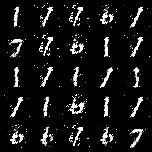

[Epoch 59/200] [D loss: 0.156075] [G loss: 2.099786]
[Epoch 60/200] [D loss: 0.169131] [G loss: 3.689749]


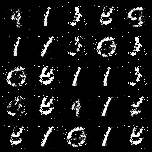

[Epoch 61/200] [D loss: 0.170172] [G loss: 3.562409]
[Epoch 62/200] [D loss: 0.092110] [G loss: 4.888257]


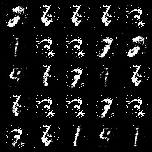

[Epoch 63/200] [D loss: 0.081375] [G loss: 3.388877]
[Epoch 64/200] [D loss: 0.266509] [G loss: 1.861946]
[Epoch 65/200] [D loss: 0.201431] [G loss: 2.239025]


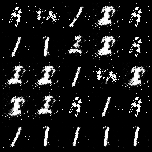

[Epoch 66/200] [D loss: 0.111233] [G loss: 2.768893]
[Epoch 67/200] [D loss: 0.171710] [G loss: 3.850220]


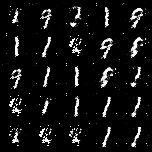

[Epoch 68/200] [D loss: 0.289219] [G loss: 3.899027]
[Epoch 69/200] [D loss: 0.159710] [G loss: 2.581839]


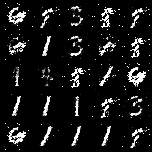

[Epoch 70/200] [D loss: 0.190185] [G loss: 1.373677]
[Epoch 71/200] [D loss: 0.077571] [G loss: 3.129608]


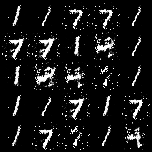

[Epoch 72/200] [D loss: 0.158302] [G loss: 2.766864]
[Epoch 73/200] [D loss: 0.053327] [G loss: 3.279009]


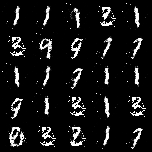

[Epoch 74/200] [D loss: 0.135080] [G loss: 5.546195]
[Epoch 75/200] [D loss: 0.067069] [G loss: 5.386114]


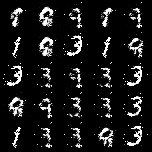

[Epoch 76/200] [D loss: 0.124030] [G loss: 1.846740]
[Epoch 77/200] [D loss: 0.264465] [G loss: 2.251499]


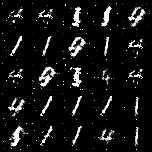

[Epoch 78/200] [D loss: 0.131806] [G loss: 2.090983]
[Epoch 79/200] [D loss: 0.406737] [G loss: 5.333191]
[Epoch 80/200] [D loss: 0.082109] [G loss: 3.169164]


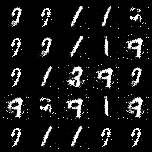

[Epoch 81/200] [D loss: 0.134963] [G loss: 2.867945]
[Epoch 82/200] [D loss: 0.126707] [G loss: 4.184943]


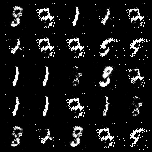

[Epoch 83/200] [D loss: 0.074065] [G loss: 2.661467]
[Epoch 84/200] [D loss: 0.067023] [G loss: 3.961424]


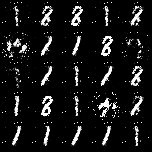

[Epoch 85/200] [D loss: 0.486392] [G loss: 0.636845]
[Epoch 86/200] [D loss: 0.471013] [G loss: 6.753734]


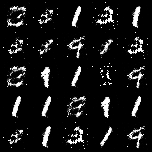

[Epoch 87/200] [D loss: 0.180010] [G loss: 4.566802]
[Epoch 88/200] [D loss: 0.135029] [G loss: 3.061303]


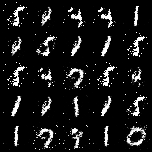

[Epoch 89/200] [D loss: 0.122891] [G loss: 3.040969]
[Epoch 90/200] [D loss: 0.124406] [G loss: 2.272064]


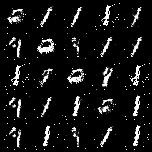

[Epoch 91/200] [D loss: 0.111124] [G loss: 3.272915]
[Epoch 92/200] [D loss: 0.298725] [G loss: 3.725954]


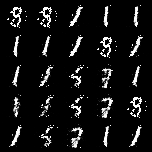

[Epoch 93/200] [D loss: 0.165963] [G loss: 2.401544]
[Epoch 94/200] [D loss: 0.263149] [G loss: 3.922093]


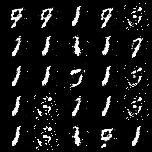

[Epoch 95/200] [D loss: 0.158323] [G loss: 3.477714]
[Epoch 96/200] [D loss: 0.153723] [G loss: 4.076429]
[Epoch 97/200] [D loss: 0.659518] [G loss: 12.104359]


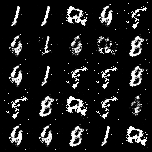

[Epoch 98/200] [D loss: 0.069658] [G loss: 2.563983]
[Epoch 99/200] [D loss: 0.179063] [G loss: 2.656114]


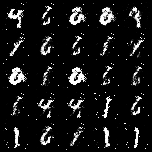

[Epoch 100/200] [D loss: 0.117607] [G loss: 3.493450]
[Epoch 101/200] [D loss: 0.081659] [G loss: 2.859363]


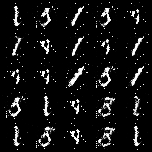

[Epoch 102/200] [D loss: 0.252150] [G loss: 1.606182]
[Epoch 103/200] [D loss: 0.143420] [G loss: 3.703987]


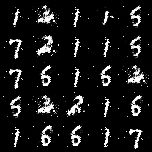

[Epoch 104/200] [D loss: 0.284671] [G loss: 3.426007]
[Epoch 105/200] [D loss: 0.373814] [G loss: 1.511000]


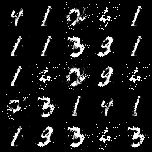

[Epoch 106/200] [D loss: 0.125285] [G loss: 3.128916]
[Epoch 107/200] [D loss: 0.179201] [G loss: 4.553196]


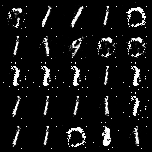

[Epoch 108/200] [D loss: 0.117795] [G loss: 2.623226]
[Epoch 109/200] [D loss: 0.184210] [G loss: 2.602610]


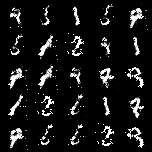

[Epoch 110/200] [D loss: 0.161332] [G loss: 2.152328]
[Epoch 111/200] [D loss: 0.300063] [G loss: 3.667793]
[Epoch 112/200] [D loss: 0.157109] [G loss: 3.052928]


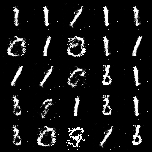

[Epoch 113/200] [D loss: 0.212262] [G loss: 3.177165]
[Epoch 114/200] [D loss: 0.098381] [G loss: 5.008399]


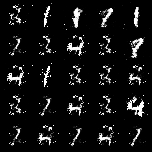

[Epoch 115/200] [D loss: 0.265594] [G loss: 3.378647]
[Epoch 116/200] [D loss: 0.153553] [G loss: 4.737234]


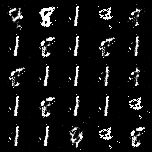

[Epoch 117/200] [D loss: 0.164351] [G loss: 2.306523]
[Epoch 118/200] [D loss: 0.207286] [G loss: 2.006260]


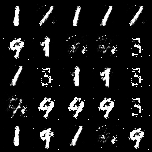

[Epoch 119/200] [D loss: 0.348321] [G loss: 6.094616]
[Epoch 120/200] [D loss: 0.506832] [G loss: 5.394019]


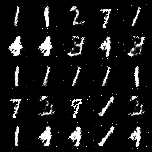

[Epoch 121/200] [D loss: 0.060520] [G loss: 2.924345]
[Epoch 122/200] [D loss: 0.397863] [G loss: 4.015286]


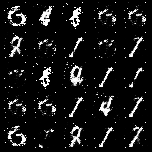

[Epoch 123/200] [D loss: 0.176484] [G loss: 3.705515]
[Epoch 124/200] [D loss: 0.297568] [G loss: 3.533153]


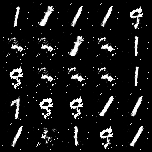

[Epoch 125/200] [D loss: 0.176066] [G loss: 1.687765]
[Epoch 126/200] [D loss: 0.200695] [G loss: 3.660504]


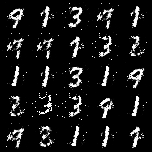

[Epoch 127/200] [D loss: 0.018889] [G loss: 4.390789]
[Epoch 128/200] [D loss: 0.250942] [G loss: 8.246230]
[Epoch 129/200] [D loss: 0.077930] [G loss: 3.447649]


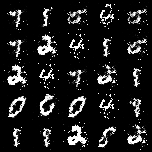

[Epoch 130/200] [D loss: 0.289481] [G loss: 4.337386]
[Epoch 131/200] [D loss: 0.187126] [G loss: 3.879910]


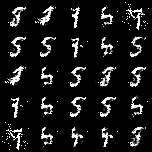

[Epoch 132/200] [D loss: 0.191126] [G loss: 3.135746]
[Epoch 133/200] [D loss: 0.087965] [G loss: 3.688254]


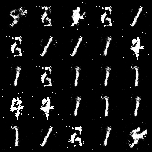

[Epoch 134/200] [D loss: 0.029279] [G loss: 3.943050]
[Epoch 135/200] [D loss: 0.342155] [G loss: 4.264629]


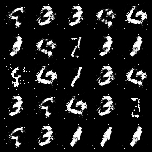

[Epoch 136/200] [D loss: 0.140769] [G loss: 4.986242]
[Epoch 137/200] [D loss: 0.106296] [G loss: 3.687623]


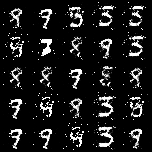

[Epoch 138/200] [D loss: 0.083421] [G loss: 3.513553]
[Epoch 139/200] [D loss: 0.134350] [G loss: 4.840437]


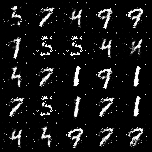

[Epoch 140/200] [D loss: 0.129222] [G loss: 2.719218]
[Epoch 141/200] [D loss: 0.165008] [G loss: 2.881629]


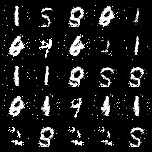

[Epoch 142/200] [D loss: 0.149894] [G loss: 3.667282]
[Epoch 143/200] [D loss: 0.246115] [G loss: 3.424947]


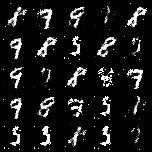

[Epoch 144/200] [D loss: 0.291903] [G loss: 4.949744]
[Epoch 145/200] [D loss: 0.113399] [G loss: 2.208006]
[Epoch 146/200] [D loss: 0.157671] [G loss: 4.394066]


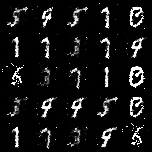

[Epoch 147/200] [D loss: 0.107595] [G loss: 3.803845]
[Epoch 148/200] [D loss: 0.171803] [G loss: 3.208174]


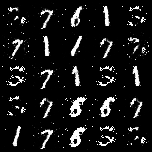

[Epoch 149/200] [D loss: 0.163514] [G loss: 4.639162]
[Epoch 150/200] [D loss: 0.157671] [G loss: 3.665175]


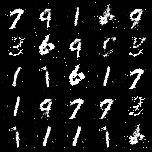

[Epoch 151/200] [D loss: 0.312161] [G loss: 2.886933]
[Epoch 152/200] [D loss: 0.154149] [G loss: 3.314242]


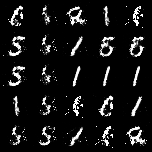

[Epoch 153/200] [D loss: 0.210316] [G loss: 2.206719]
[Epoch 154/200] [D loss: 0.110122] [G loss: 4.290408]


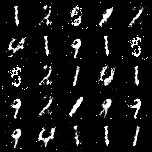

[Epoch 155/200] [D loss: 0.245445] [G loss: 3.582953]
[Epoch 156/200] [D loss: 0.075209] [G loss: 4.204104]


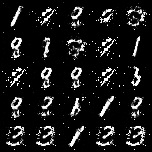

[Epoch 157/200] [D loss: 0.167585] [G loss: 1.949214]
[Epoch 158/200] [D loss: 0.125041] [G loss: 3.419594]


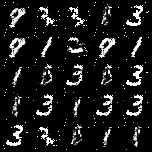

[Epoch 159/200] [D loss: 0.053102] [G loss: 3.051237]
[Epoch 160/200] [D loss: 0.195443] [G loss: 3.422495]
[Epoch 161/200] [D loss: 0.073901] [G loss: 3.059986]


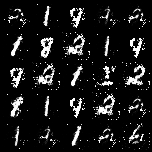

[Epoch 162/200] [D loss: 0.239816] [G loss: 3.210209]
[Epoch 163/200] [D loss: 0.099352] [G loss: 2.767146]


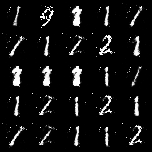

[Epoch 164/200] [D loss: 0.245811] [G loss: 4.578866]
[Epoch 165/200] [D loss: 0.148835] [G loss: 3.167204]


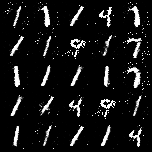

[Epoch 166/200] [D loss: 0.254193] [G loss: 2.744649]
[Epoch 167/200] [D loss: 0.240791] [G loss: 1.423082]


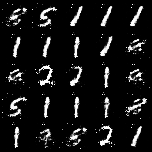

[Epoch 168/200] [D loss: 0.076199] [G loss: 3.261222]
[Epoch 169/200] [D loss: 0.321307] [G loss: 1.549590]


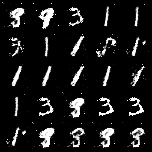

[Epoch 170/200] [D loss: 0.166600] [G loss: 1.819796]
[Epoch 171/200] [D loss: 0.089187] [G loss: 2.650809]


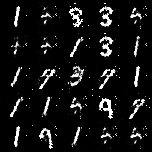

[Epoch 172/200] [D loss: 0.152181] [G loss: 2.626197]
[Epoch 173/200] [D loss: 0.073053] [G loss: 6.899108]


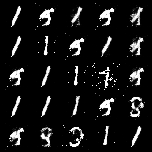

[Epoch 174/200] [D loss: 0.211753] [G loss: 2.557168]
[Epoch 175/200] [D loss: 0.072583] [G loss: 3.403070]


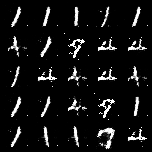

[Epoch 176/200] [D loss: 0.050341] [G loss: 3.453680]
[Epoch 177/200] [D loss: 0.264084] [G loss: 2.338827]
[Epoch 178/200] [D loss: 0.146894] [G loss: 4.061787]


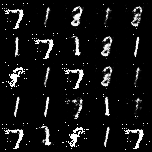

[Epoch 179/200] [D loss: 0.235271] [G loss: 3.487029]
[Epoch 180/200] [D loss: 0.129718] [G loss: 3.769368]


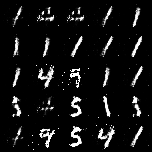

[Epoch 181/200] [D loss: 0.318826] [G loss: 1.181039]
[Epoch 182/200] [D loss: 0.063113] [G loss: 3.284440]


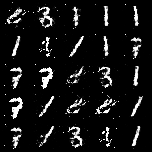

[Epoch 183/200] [D loss: 0.140454] [G loss: 4.217750]
[Epoch 184/200] [D loss: 0.272303] [G loss: 2.374349]


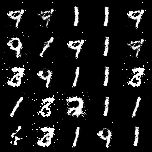

[Epoch 185/200] [D loss: 0.219459] [G loss: 2.610547]
[Epoch 186/200] [D loss: 0.363822] [G loss: 3.072037]


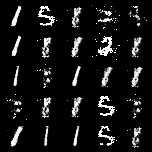

[Epoch 187/200] [D loss: 0.193407] [G loss: 3.323548]
[Epoch 188/200] [D loss: 0.109304] [G loss: 5.094286]


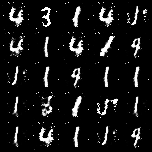

[Epoch 189/200] [D loss: 0.222660] [G loss: 4.150972]
[Epoch 190/200] [D loss: 0.148453] [G loss: 4.623425]


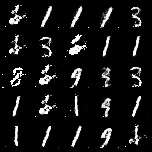

[Epoch 191/200] [D loss: 0.293226] [G loss: 3.769689]
[Epoch 192/200] [D loss: 0.155539] [G loss: 3.574918]
[Epoch 193/200] [D loss: 0.203569] [G loss: 2.818089]


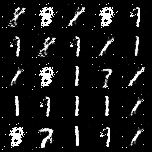

[Epoch 194/200] [D loss: 0.294143] [G loss: 3.244365]
[Epoch 195/200] [D loss: 0.142358] [G loss: 3.237177]


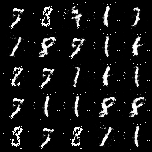

[Epoch 196/200] [D loss: 0.200383] [G loss: 2.998401]
[Epoch 197/200] [D loss: 0.110570] [G loss: 2.718446]


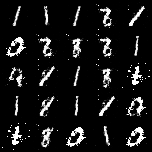

[Epoch 198/200] [D loss: 0.030193] [G loss: 4.201338]
[Epoch 199/200] [D loss: 0.289860] [G loss: 3.300349]


In [ ]:
import time
from IPython.display import Image, display

# number of epochs of training
n_epochs = 200

# interval between image samples
sample_interval = 2000

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

"""
Training loop

Args:
    dataloader (troch.utils.data.DataLoader): Provides training images.
    n_epochs (int): Number of epochs for training.
    sample_interval (int): Interval to save and display generated images.

Returns:
    Logs generator and discriminator losses. Saves generated image samples.
"""

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        # real image = 1, fake image = 0
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        ## random sampling value z to Generator
        generated_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # Update Generator
        g_loss.backward()
        optimizer_G.step()

        #  Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Update Discriminator
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            img_path = f"data{epoch}.png"
            save_image(generated_imgs.data[:25], img_path, nrow=5, normalize=True)
            display(Image(filename=img_path))

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")